In [25]:
import time
import importlib

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.axes as ax
import seaborn as sns

import scipy
from scipy.stats import pearsonr

import tensorflow as tf
from Modules import utils, tf_utils, plot_utils, models
from Modules.tf_utils import mae_cor, correlate

In [2]:
importlib.reload(utils)
importlib.reload(tf_utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [26]:
importlib.reload(models)
model = models.inception_dna_v1(101)
print(model.summary())
del model

Model: "inception_dna_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 101, 4)]     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 101, 32)      416         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 101, 64)      1600        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 101, 16)      592         input_4[0][0]                    
___________________________________________________________________________________

In [7]:
model = models.mnase_Maxime(2001)
print(model.summary())
del model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 1999, 32)          416       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 999, 32)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 999, 32)           128       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 990, 32)           10272     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 495, 32)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 495, 32)           128       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 476, 32)           2

In [3]:
with np.load(Path(data_dir, 'SCerevisiae', 'genome', 'W303', 'W303.npz')) as f:
    x_train = f['chr02']
    x_valid = f['chr14']
    x_test = f['chr16']
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase.npz')) as f:
    y_train = f['chr02']
    y_valid = f['chr14']
    y_test = f['chr16']
x_train.shape

(844051, 4)

In [6]:
def valid_windows(one_hot_chr, labels, winsize):
    N_mask = (np.sum(one_hot_chr, axis=1) == 0)
    N_window_mask = np.asarray(
        np.convolve(N_mask, np.ones(winsize), mode='same'),
        dtype=int)
    valid_window_mask = (N_window_mask == 0) & (labels != 0).ravel()
    indexes = np.arange(len(one_hot_chr))[valid_window_mask]
    indexes = indexes[
        (indexes >= winsize // 2)
        & (indexes < len(one_hot_chr) - (winsize // 2))]
    return indexes

In [7]:
x_eff = valid_windows(x_valid, y_valid, 2001)
len(x_eff)

764064

In [17]:
gen_x = tf_utils.WindowGenerator(x_valid, y_valid, 2001, 1024, 2**22)
gen_x.max_data

238115

In [15]:
2**20

1048576

In [8]:
def predict(model, one_hot_chr, winsize=2001):
    X = utils.chunk_chr(one_hot_chr, 2001)[1]
    pred = np.zeros(len(one_hot_chr))
    pred[winsize//2:-(winsize//2)] = model.predict(X)[:, 0]
    return pred

In [20]:
preds = {}

In [32]:
data = 'MMusculus'
with np.load(Path(data_dir, data, 'genome', 'mm10.npz')) as f:
    x_test = f['chr3']

In [73]:
model = tf.keras.models.load_model(Path(data_dir, 'MMusculus', 'Trainedmodels', 'model_mnase_mm2', 'model'), custom_objects={"mae_cor": mae_cor, "correlate": correlate})
pred_test1 = tf_utils.predict(model, x_test[10_000_000:10_100_000], 2001)
pred_test1_rev = tf_utils.predict(model, x_test[10_000_000:10_100_000], 2001, reverse=True)
# print(model.layers[0].input_shape[1])#.input_shape[0][1])
del model

model = tf.keras.models.load_model(Path(data_dir, 'MMusculus', 'Trainedmodels', 'model_mnase_mm3', 'model'), custom_objects={"mae_cor": mae_cor, "correlate": correlate})
pred_test2 = tf_utils.predict(model, x_test[10_000_000:10_100_000], 2001)
pred_test2_rev = tf_utils.predict(model, x_test[10_000_000:10_100_000], 2001, reverse=True)
del model

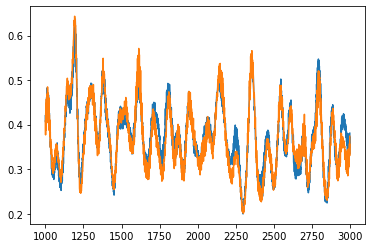

In [74]:
start = 1_000
stop = start + 2_000
plt.plot(np.arange(start, stop), pred_test1[start:stop], label='for_on_for')
plt.plot(np.arange(start, stop), pred_test1_rev[start:stop], label='for_on_rev')
# plt.plot(np.arange(start, stop), pred_test2[start:stop], label='rev_on_for')
# plt.plot(np.arange(start, stop), pred_test2_rev[start:stop], label='rev_on_rev')
plt.show()
plt.close()

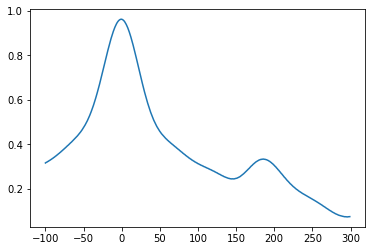

In [75]:
slide_corr = []
offsets = np.arange(-100, 300, 1)
for i in offsets:
    if i == 0:
        corr = pearsonr(pred_test1, pred_test1_rev)[0]
    elif i > 0:
        corr = pearsonr(pred_test1[i:], pred_test1_rev[:-i])[0]
    else:
        corr = pearsonr(pred_test1_rev[-i:], pred_test1[:i])[0]
    slide_corr.append(corr)
plt.plot(offsets, slide_corr)
plt.show()
plt.close()

In [71]:
def sliding_correlation(X, Y, offsets):
    slide_corr = []
    for i in offsets:
        if i == 0:
            corr = pearsonr(X, Y)[0]
        elif i > 0:
            corr = pearsonr(X[i:], Y[:-i])[0]
        else:
            corr = pearsonr(Y[-i:], X[:i])[0]
        slide_corr.append(corr)
    return slide_corr

def fast_sliding_correlation(X, Y, offsets):
    assert len(X) == len(Y)
    min_offset = np.min(offsets)
    max_offset = np.max(offsets)
    max_len = len(X) - max_offset + min_offset
    offsets -= min_offset
    windows = offsets.reshape(-1, 1) + np.arange(max_len).reshape(1, -1)
    X_slides = X[windows]
    slide_corrs = utils.lineWiseCorrcoef(X_slides, Y[-min_offset:-min_offset+max_len])
    return slide_corrs

(400, 99601)


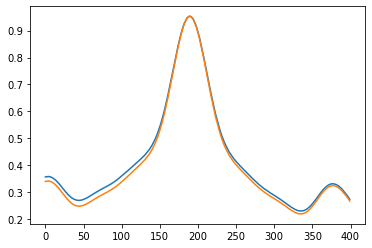

In [68]:
offsets = np.arange(-100, 300)
slide_corrs = sliding_correlation(pred_test1, pred_test1_rev, offsets)
fast_slide_corrs = fast_sliding_correlation(pred_test1, pred_test1_rev, offsets)
plt.plot(offsets, slide_corrs)
plt.plot(offsets, fast_slide_corrs)
plt.show()
plt.close()

In [69]:
%%timeit
sliding_correlation(pred_test1, pred_test1_rev, np.arange(-100, 300))

202 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
%%timeit
fast_sliding_correlation(pred_test1, pred_test1_rev, np.arange(-100, 300))

221 ms ± 362 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
# preds['model_mnase_11'] = [pred_test, pred_valid, pred_train, pred_test_rev, pred_valid_rev, pred_train_rev]
# preds['model_mnase_12'] = [pred_test, pred_valid, pred_train, pred_test_rev, pred_valid_rev, pred_train_rev]
preds['model_mnase_13'] = [pred_test, pred_valid, pred_train, pred_test_rev, pred_valid_rev, pred_train_rev]
for pred_model in preds.keys():
    print(pred_model)

model_mnase_11
model_mnase_13


In [19]:
test_corrs = np.corrcoef([y_test, pred_test, pred_test_rev])
valid_corrs = np.corrcoef([y_valid, pred_valid, pred_valid_rev])
train_corrs = np.corrcoef([y_train, pred_train, pred_train_rev])
test_corrs, valid_corrs, train_corrs

(array([[1.        , 0.57081365, 0.5822789 ],
        [0.57081365, 1.        , 0.66006644],
        [0.5822789 , 0.66006644, 1.        ]]),
 array([[1.        , 0.56816693, 0.56442126],
        [0.56816693, 1.        , 0.62536211],
        [0.56442126, 0.62536211, 1.        ]]),
 array([[1.        , 0.8913237 , 0.57227383],
        [0.8913237 , 1.        , 0.62596317],
        [0.57227383, 0.62596317, 1.        ]]))

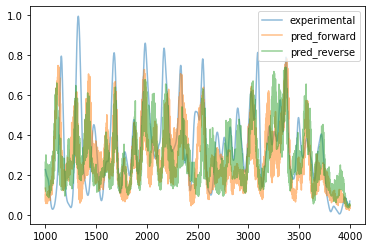

In [25]:
start = 1000
stop = start + 3000 # len(pred_train)
plt.plot(np.arange(start, stop), y_test[start:stop], label='experimental', alpha=0.5)
plt.plot(np.arange(start, stop), pred_test[start:stop], label='pred_forward', alpha=0.5)
plt.plot(np.arange(start, stop), pred_test_rev[start:stop], label='pred_reverse', alpha=0.5)
plt.legend()
plt.show()
plt.close()

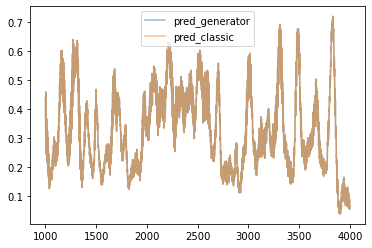

In [36]:
start = 1000
stop = start + 3000 # len(pred_train)
plt.plot(np.arange(start, stop), pred_test_rev[start:stop], label='pred_generator', alpha=0.5)
plt.plot(np.arange(start, stop), pred_test2_rev[start:stop], label='pred_classic', alpha=0.5)
plt.legend()
plt.show()
plt.close()

In [36]:
def merge_chroms(chr_ids, file):
    annot = []
    with np.load(file) as f:
        for chr_id in chr_ids:
            annot.append(f[chr_id])
            shape, dtype = f[chr_id].shape, f[chr_id].dtype
            annot.append(np.zeros((1,)+shape[1:], dtype=dtype))
    return np.concatenate(annot)

In [43]:
a = merge_chroms(['chr01', 'chr02', 'chr03', 'chr04', 'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10', 'chr11', 'chr12', 'chr13'], Path(data_dir, 'SCerevisiae', 'genome', 'W303', 'W303.npz'))
a.shape

(9409640, 4)

In [44]:
b = merge_chroms(['chr01', 'chr02', 'chr03', 'chr04', 'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10', 'chr11', 'chr12', 'chr13'], Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase.npz'))
b.shape

(9409640,)

: 